# **РК 2** *Дубянский А. И., ИУ5Ц-81Б*

# 0. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, plot_roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# отбираем 5000 строк из всего датасета
data = pd.read_csv('data.csv', nrows=5000)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5000 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5000 non-null   float64
 2    ROA(A) before interest and % after tax                   5000 non-null   float64
 3    ROA(B) before interest and depreciation after tax        5000 non-null   float64
 4    Operating Gross Margin                                   5000 non-null   float64
 5    Realized Sales Gross Margin                              5000 non-null   float64
 6    Operating Profit Rate                                    5000 non-null   float64
 7    Pre-tax net Interest Rate                                5000 non-null   float64
 8    After-tax net Int

In [4]:
# Оцениваем баланс классов целевого признака
data['Bankrupt?'].value_counts()/data['Bankrupt?'].shape[0]*100

0    96.16
1     3.84
Name: Bankrupt?, dtype: float64

In [5]:
# Проверяем процент пропусков в данных для всех колонок
(data.isnull().sum()/data.shape[0]*100).sort_values(ascending=False)

Bankrupt?                                                   0.0
 ROA(C) before interest and depreciation before interest    0.0
 Total expense/Assets                                       0.0
 Total income/Total expense                                 0.0
 Retained Earnings to Total Assets                          0.0
                                                           ... 
 Total Asset Growth Rate                                    0.0
 Continuous Net Profit Growth Rate                          0.0
 Regular Net Profit Growth Rate                             0.0
 After-tax Net Profit Growth Rate                           0.0
 Equity to Liability                                        0.0
Length: 96, dtype: float64

Пропусков нет, так что двигаемся дальше


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5000 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5000 non-null   float64
 2    ROA(A) before interest and % after tax                   5000 non-null   float64
 3    ROA(B) before interest and depreciation after tax        5000 non-null   float64
 4    Operating Gross Margin                                   5000 non-null   float64
 5    Realized Sales Gross Margin                              5000 non-null   float64
 6    Operating Profit Rate                                    5000 non-null   float64
 7    Pre-tax net Interest Rate                                5000 non-null   float64
 8    After-tax net Int

In [7]:
# Проверяем категориальные признаки на уникальность
col_obj = data.dtypes[data.dtypes==object].index.values.tolist()
for i in enumerate(col_obj):
    uniq_obj = data[i[1]].unique()
    print(f'{i[0]+1}. {i[1]}: {uniq_obj} | КОЛ-ВО: {len(uniq_obj)}')

In [8]:
# Копируем датасет и применяем label-encoding категориальных признаков для составления корреляционной матрицы 
# и последующего применения в модели Random Forest
dataLE = data.copy()
le = LabelEncoder()
col_obj = dataLE.dtypes[dataLE.dtypes==object].index.values.tolist()
for i in col_obj:
    dataLE[i] = le.fit_transform(dataLE[i])

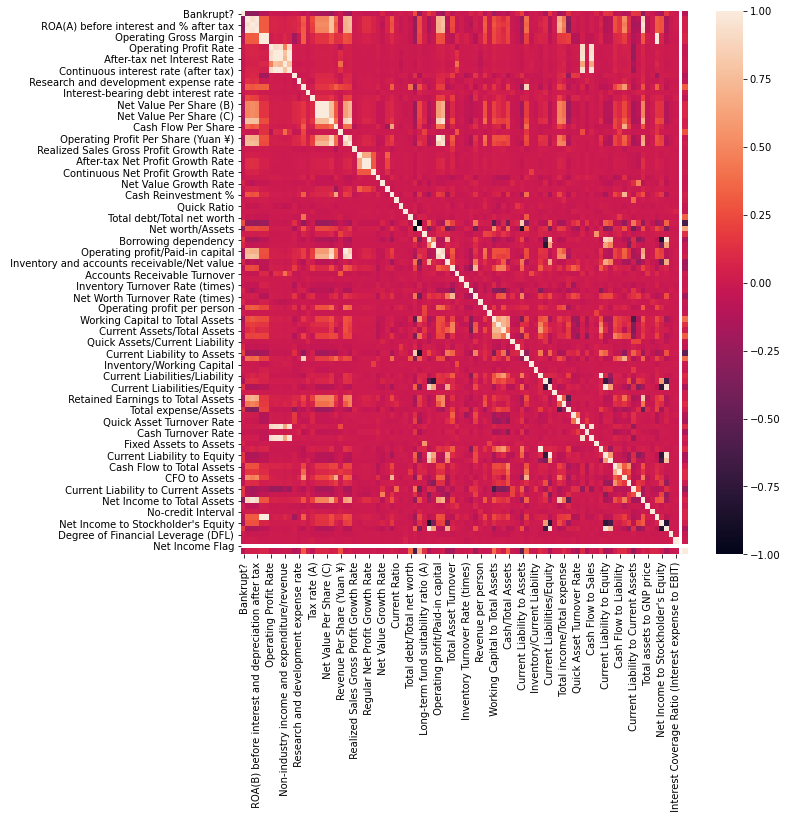

In [9]:
plt.figure(figsize=(10,10))
g = sns.heatmap(dataLE.corr())

In [11]:
# Оцениваем важность признаков для целевого
(dataLE.corr()['Bankrupt?']*100).sort_values(ascending=False)

Bankrupt?                                                   100.000000
 Debt ratio %                                                25.156912
 Current Liability to Assets                                 19.455953
 Current Liability to Current Assets                         16.821188
 Borrowing dependency                                        16.573621
                                                               ...    
 ROA(C) before interest and depreciation before interest    -26.626365
 ROA(B) before interest and depreciation after tax          -27.422565
 ROA(A) before interest and % after tax                     -27.957001
 Net Income to Total Assets                                 -30.493039
 Net Income Flag                                                   NaN
Name: Bankrupt?, Length: 96, dtype: float64

По результатам корреляционного анализа удаляем столбцы, которые имеют меньшую значимость по отношению к целевому признаку

In [12]:
del_data = (dataLE.corr()['Bankrupt?']*100).sort_values(ascending=False)
del_col = del_data[(del_data < 10) & (del_data > -10) | (del_data.isnull())].index.values.tolist()
data.drop(columns=del_col, inplace=True)
dataLE.drop(columns=del_col, inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5000 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5000 non-null   float64
 2    ROA(A) before interest and % after tax                   5000 non-null   float64
 3    ROA(B) before interest and depreciation after tax        5000 non-null   float64
 4    Tax rate (A)                                             5000 non-null   float64
 5    Net Value Per Share (B)                                  5000 non-null   float64
 6    Net Value Per Share (A)                                  5000 non-null   float64
 7    Net Value Per Share (C)                                  5000 non-null   float64
 8    Persistent EPS in

Выполняем One-hot encoding для категориальных признаков и масштабирование числовых признаков для применения в SVM

In [14]:
# Выполняем one-hot encoding и масштабирование для применения в SVM
col_num = data.dtypes[data.dtypes!=object].index.values.tolist()
col_num.remove('Bankrupt?')
se = StandardScaler()
data[col_num] = se.fit_transform(data[col_num])
data = pd.get_dummies(data, drop_first=True)

In [15]:
TEST_SIZE = 0.3
RANDOM_STATE = 0

In [16]:
dataLE_X = dataLE.drop(columns='Bankrupt?')
dataLE_y = dataLE['Bankrupt?']
data_X = data.drop(columns='Bankrupt?')
data_y = data['Bankrupt?']

In [17]:
dataLE_X_train, dataLE_X_test, dataLE_y_train, dataLE_y_test = train_test_split(dataLE_X, dataLE_y, \
                                                                                test_size = TEST_SIZE, \
                                                                                random_state= RANDOM_STATE)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, data_y, \
                                                                        test_size = TEST_SIZE, \
                                                                        random_state= RANDOM_STATE)

In [18]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    print(f'Сбалансированная оценка: {balanced_accuracy_score(Y_test, target)}')
    fig, ax = plt.subplots()
    plot_roc_curve(clf, X_test, Y_test, ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    print(f'Матрица ошибок:\n {confusion_matrix(Y_test, target)}')

# 1. SVM

Сбалансированная оценка: 0.5096551724137931


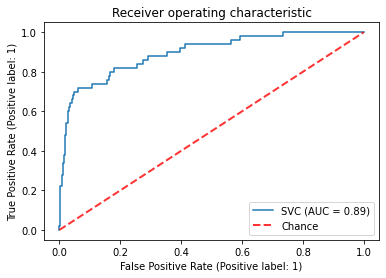

Матрица ошибок:
 [[1449    1]
 [  49    1]]


In [19]:
print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, SVC(random_state=RANDOM_STATE))

# 2. Random Forest

Сбалансированная оценка: 0.5886206896551724


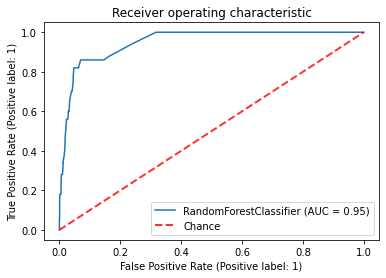

Матрица ошибок:
 [[1446    4]
 [  41    9]]


In [20]:
print_metrics(dataLE_X_train, dataLE_y_train, dataLE_X_test, dataLE_y_test, RandomForestClassifier(random_state=RANDOM_STATE))

# 3. Выводы

В данной работе для оценки моделей были использованы следующие метрики, подходящие для задачи бинарной классификации:
- **balanced accuracy**, так как данная метрика хорошо интерпретируется и используется при несбалансированных классах
- **ROC-кривая (AUC)**, так как позволяет по графику понять, насколько модель может минимизировать FP (False Positive), т.е. признавать отмененным заказ, который таковым не является, и минимизировать FN (False Negative), т.е. признавать бронированным заказ, который был отменен
- **confusion matrix**, так как, хотя и метрикой в полной мере не является, позволяет увидеть общую картину по всем видам ошибок.

По результатам оценивания можно сделать следующий вывод: модель Random Forest обладает немного большей предсказательной способностью, чем Support Vector Machine. Но при этом обе модели могут использоваться для предсказания, будет ли заказ по бронированию отменен, с минимальным количеством ошибок.